# Model Usage

In [1]:
import numpy as np
from py.model import *
from SpringRank import SpringRank
from matplotlib import pyplot as plt

This is a quick example of how to use the software I've been writing to conduct simulations like the ones you've been doing so far. I've intentionally tried to replicate most of the experiments in the current version of async_mk.ipynb, although I haven't nailed every detail. 

The first thing to do is initialize an instance of the `model` class. The aim of this class is to provide methods for both simulation and inference that enable one to easily store relevant information. 

In [2]:
M = model()

The model is intended to be flexible. It's necessary to specify both the *score function* and the *feature map(s)* you want to use. Examples of score functions include SpringRank, in-degree rank, etc.  

In [3]:
# the score function should take in an n x n matrix and return an n-vector. 

M.set_score(
    score_function = lambda A: SpringRank.SpringRank(A.T, alpha = .01)
)

# indegree would be: 
# score_function  lambda A: A.sum(axis = 0)

Next, it's necessary to specify the feature map: how is the score function transformed before it gets fed into the exponential? We've been working almost exclusively with *linear* features: 

In [4]:
# each feature function should take in an n-vector (the score) and return an n x n matrix. 
linear_feature = lambda s: np.tile(s, (len(s),1))

M.set_features([linear_feature]) # needs to be a list of features

Now we've configured the model `M` so that it replicates our familiar dynamics. Ready to simulate!

In [5]:
A0 = np.random.rand(10, 10) # initial state

T = M.simulate(lam = .98, 
               beta = np.array([2.5]), # needs to be a vector
               A0 = A0, 
               n_rounds = 1000, 
               update = stochastic_update, # or deterministic_update
               m_updates = 1)

Now, `T` holds the sequence of "observed" states. We might instead want the state matrix `A`, the rate matrices `GAMMA`, or the scores `S`.   

In [6]:
A = M.get_states()
GAMMA = M.get_rates()
S = M.get_scores()

`GAMMA` is supplied as a sequence of matrices, not vectors. To get the vector version which we've been using, just compute the mean along the first axis: 

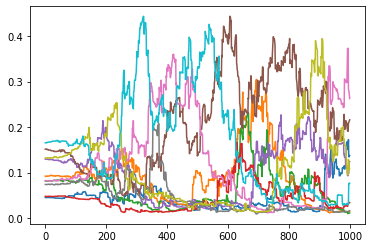

In [7]:
p = plt.plot(GAMMA.mean(axis = 1))

So, to recap, to go from parameters to a basic plot, you would do this: 


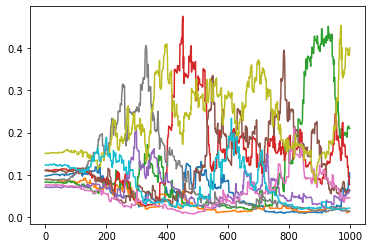

In [8]:
# initialize the model
M = model()
M.set_score(
    score_function = lambda A: SpringRank.SpringRank(A.T, alpha = .01)
)

linear_feature = lambda s: np.tile(s, (len(s),1))
M.set_features([linear_feature]) 

# do the simulation
A0 = np.random.rand(10, 10)
T = M.simulate(lam = .98, 
               beta = np.array([2.5]), # needs to be a vector
               A0 = A0, 
               n_rounds = 1000, 
               update = stochastic_update, # or deterministic_update
               m_updates = 1)

# grab the result and plot it           
GAMMA = M.get_rates()
p = plt.plot(GAMMA.mean(axis = 1))

# Batch Example

Here's a quick example where we reproduce the figure at the bottom of `async_mk.ipynb`. 

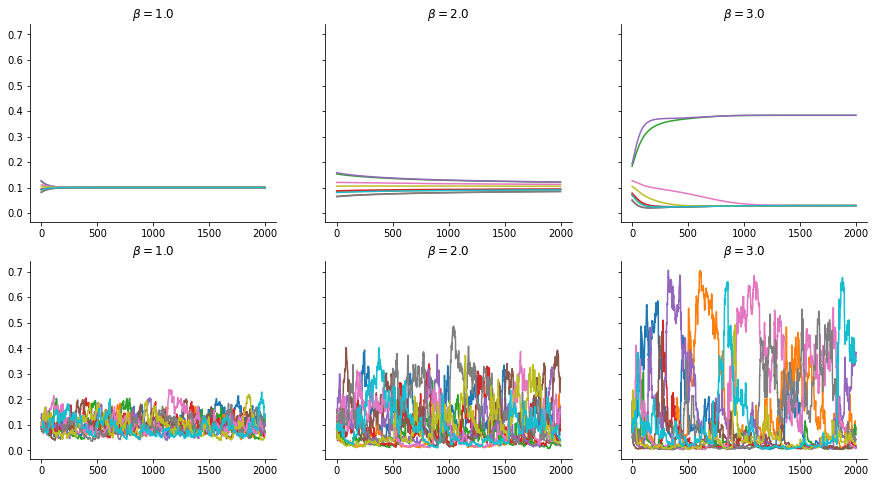

In [9]:
# parameters for the fig

m_plots = 3
BETAS = np.linspace(1, 3, m_plots)
methods = [deterministic_update, stochastic_update]

n_rounds = 2000
lam = .97

n = 10

# initial condition

A0 = np.random.rand(n,n)
A0 = A0 / A0.sum()

# initialize the model

M = model()
M.set_score(
    score_function = lambda A: SpringRank.SpringRank(A.T, alpha = 10**(-15))
)
linear_feature = lambda s: np.tile(s, (len(s),1))
M.set_features([linear_feature])

# create fig

fig, axarr = plt.subplots(len(methods), m_plots, figsize = (15, 8), squeeze = False, sharey = True)

# loop through axs, doing a simulation for each and plotting. 

for k in range(len(methods)):
    for i in range(m_plots):
        T = M.simulate(lam = lam,
                       beta = np.array([BETAS[i]]), 
                       A0 = A0, 
                       n_rounds = n_rounds, 
                       update = methods[k], 
                       m_updates = 1)
        GAMMA = M.get_rates()
        axarr[k][i].plot(GAMMA.mean(axis = 1))
        
        axarr[k][i].spines['right'].set_visible(False)
        axarr[k][i].spines['top'].set_visible(False)
        
        axarr[k][i].set_title(r'$\beta = $' + str(BETAS[i]))

Hopefully this will help rather than hinder as you do your magic. I'd love feedback on the software to make it easier to understand and use! 